# import library

In [1]:
import os
import pickle 
import numpy as np
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
base_dir = 'D:\KULIAH\SEMESTER 4\Big data\prototype lstm'

# convert image into array

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
features = {}
directory = os.path.join(base_dir,'Flicker8k_Dataset')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0],image.shape[1], image.shape[2]))
    image = preprocess_input(image) 
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split('.')[0]
    features[image_id]=feature


  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [127]:
#write PKL file

pickle.dump(features, open(os.path.join(base_dir, 'features.pkl'),'wb')) 

In [4]:
#read PKL file
with open(os.path.join(base_dir, 'features.pkl'),'rb') as f :
    features = pickle.load(f)

# prepocess for caption dataset

In [33]:
#open for capton file

with open(os.path.join(base_dir, 'captions.txt'),'r') as f:
    captions_doc = f.read()

In [34]:
mapping = {}

for line in tqdm(captions_doc.split("\n")):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40457 [00:00<?, ?it/s]

In [35]:
caption

'A rock climber practices on a rock climbing wall .'

In [36]:
len(mapping)

8092

In [37]:
mapping

{'image': ['caption'],
 '1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on 

In [38]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+',' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            
            captions[i] = caption

In [39]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [40]:
clean(mapping)

In [41]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [42]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [43]:
len(all_captions)

40456

In [44]:
all_captions[:10]

['startseq caption endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq']

In [45]:
#tokenize caption text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [46]:
vocab_size

8486

In [47]:
#maximum caption length

max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [48]:
#train test split

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [49]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 

In [50]:
#data generator

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1 :
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                sq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sq)):
                    inp_sq, out_sq = sq[:i], sq[i]
                    
                    inp_sq = pad_sequences([inp_sq], maxlen = max_length)[0]
                    out_sq = to_categorical([out_sq], num_classes = vocab_size)[0]
                    
                    #store sequence
                    x1.append(features[key][0])
                    x2.append(inp_sq)
                    y.append(out_sq)
                    
            if n == batch_size:
                x1, x2, y = np.array(x1),np.array(x2),np.array(y)
                yield[x1,x2],y
                x1,x2,y = list(), list(), list()
                n = 0


# CNN-LSTM MODELING

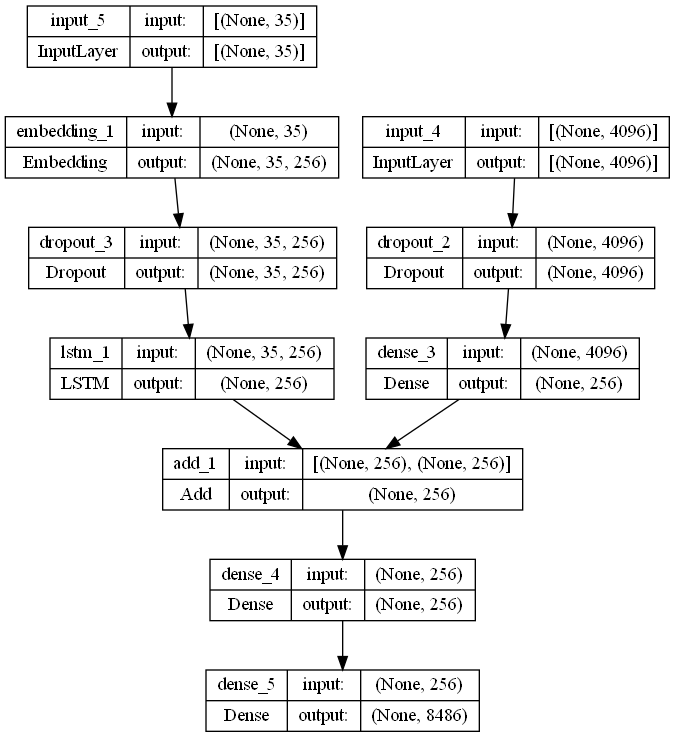

In [51]:
# CNN-LSTM MODEL

# encode
inputs_1 = Input(shape=(4096,))
featNN1 = Dropout(0.4)(inputs_1)
featNN2 = Dense(256, activation='relu')(featNN1)

inputs_2 = Input(shape =(max_length,))
seq_1 = Embedding(vocab_size, 256, mask_zero = True)(inputs_2)
seq_2 = Dropout(0.4)(seq_1)
seq_3 = LSTM(256)(seq_2)

# decode
decoder_1 = add([featNN2, seq_3])
decoder_2 = Dense(256,activation = 'relu')(decoder_1)
outputs = Dense(vocab_size, activation='softmax')(decoder_2)

model = Model(inputs=[inputs_1,inputs_2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [57]:
epochs = 50
batch_size = 80
steps = len(train) // batch_size 

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 2/91 [..............................] - ETA: 6:50 - loss: 8.8476 

KeyboardInterrupt: 

In [67]:
model.save(base_dir + '/best_model2.h5')

In [52]:
model = load_model('best_model2.h5')

In [53]:
def idxToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer :
            return word
    return None

In [54]:
def make_caption(model, image, tokenizer, max_length):
    inp_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([inp_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idxToWord(yhat, tokenizer)
        if word is None :
            break
        inp_text += " " + word
        if word == 'endseq':
            break
    return inp_text

In [26]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = make_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

In [56]:

def generate_caption(image_name):
    #img_name = '1000268201_693b08cb0e.jpg'
    image_id = image_name.split('.')[0]
    imPath = os.path.join(base_dir,"Flicker8k_Dataset",image_name)
    image = Image.open(imPath)
    captions = mapping[image_id]
    print('--------------------------------------------------------')
    for caption in captions:
        print(caption)
    pred = make_caption(model,features[image_id],tokenizer, max_length)

    print('--------------------------------------------------------')
    print(pred.replace('startseq','').replace('endseq',''))
    plt.imshow(image)


--------------------------------------------------------
startseq black dog is poised to catch frisbee endseq
startseq brown dog runs after red frisbee endseq
startseq dog in the foggy distance catching frisbee endseq
startseq "a dog runs through grass while frisbee flies through the air ." endseq
startseq animal running after frisbee in field endseq
--------------------------------------------------------
 man in wetsuit is playing in the air on green ramp 


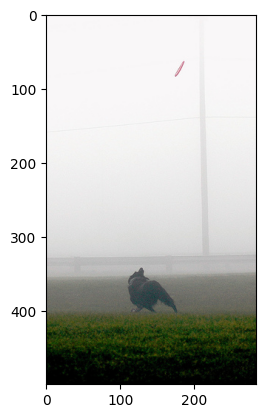

In [70]:
generate_caption('574274795_57e0834e7d.jpg')